In [37]:
# %pip install -q numpyro getdist
# %pip install -q git+https://github.com/DifferentiableUniverseInitiative/JaxPM.git
!hostname
!python -c "import jax; print(jax.default_backend())"

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.90' # NOTE: jax preallocates GPU (default 75%)
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
from getdist import plots, MCSamples

from jax import numpy as jnp, random as jr, jit, grad, value_and_grad, vmap, tree
from jax.experimental.ode import odeint

import jax_cosmo as jc
from jaxpm.painting import cic_paint, cic_read, compensate_cic
from jaxpm.pm import linear_field, lpt, make_ode_fn
from jaxpm.kernels import fftk

import numpyro.distributions as dist
from numpyro import sample, deterministic, plate, infer, render_model
from numpyro.handlers import seed, condition, trace
from numpyro.infer.util import log_density


%matplotlib inline
%load_ext autoreload
%autoreload 2

feynmangpu04.cluster.local


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/pty.py:95: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


gpu
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Probabilistic Programming Language: introductory example

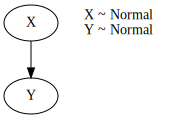

In [44]:
def model():
    x = sample('X', dist.Normal(0, 1))
    y = sample('Y', dist.Normal(x**2, 1))
    return y

render_model(model, render_distributions=True)

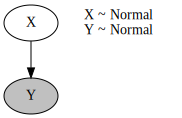

In [70]:
# Handle random seeds for reproducibility
seeded_model = seed(model, 42)

# Sample from model
y_obs = dict(Y=seeded_model())

# Condition model on variable
obs_model = condition(model, y_obs)
render_model(obs_model, render_distributions=True)

In [ ]:
# Compute log probability of model
logp_fn = lambda x, y: log_density(model,(),{},dict(X=x, Y=y))[0]

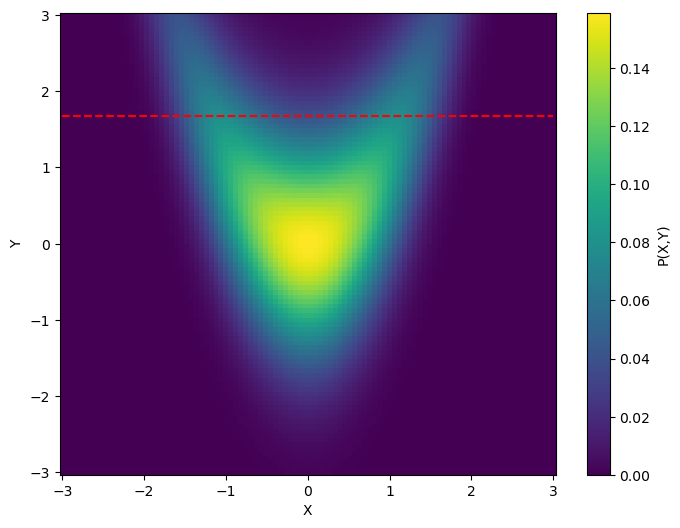

In [73]:
vlim = -3,3
n_discr = 100
xs, ys = np.linspace(*vlim, n_discr), np.linspace(*vlim, n_discr)
xy = jnp.meshgrid(xs, ys)
logps = vmap(vmap(logp_fn))(*xy)

plt.figure(figsize=(8, 6))
plt.pcolormesh(*xy, jnp.exp(logps), shading='auto', cmap='viridis')
plt.hlines(y_obs['Y'], *vlim, color='r', linestyle='--')
plt.colorbar(label='P(X,Y)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

In [80]:
kernel = infer.NUTS(obs_model)
mcmc = infer.MCMC(kernel, num_warmup=100, num_samples=1000, num_chains=8, chain_method='vectorized')
mcmc.run(jr.key(43))
samples = mcmc.get_samples()

sample: 100%|██████████| 1100/1100 [00:04<00:00, 248.31it/s]


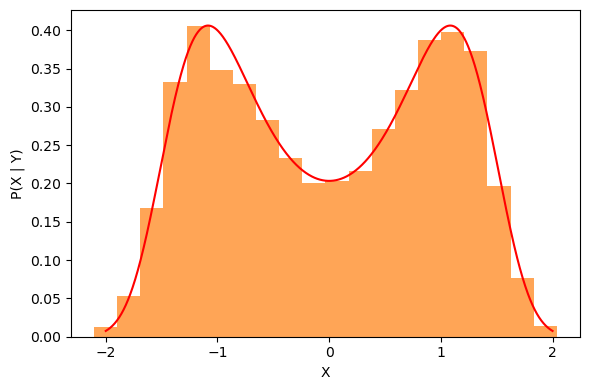

In [ ]:
plt.figure(figsize=(6,4))
xs = jnp.linspace(-2,2,1000)
logp_fn = lambda x: log_density(obs_model,(),{},dict(X=x))[0]
logps = jnp.exp(vmap(logp_fn)(xs))
logposts = logps / np.trapz(logps, xs)
plt.plot(xs, logposts, color='red')
plt.hist(samples['X'], density=True, color='tab:orange', alpha=0.7, bins=20)
plt.xlabel('X'), plt.ylabel('P(X | Y)')
plt.tight_layout()

# Sampling

### (Very) simple isotropic cosmological model
* We assume a simple eulerian linear bias isotropic model
$$\delta_H(k) \simeq b\, \sigma_8\, \delta_L(k)$$
Let's assume the shape of $\delta_L(k)$ as already been taken into account, e.g. to constraint $\Omega_m$. The information left is its amplitude.

* The likelihood is thus $$\begin{align*}
\delta_H(k) \mid  b, \sigma_8 \sim \cN(0, (b\, \sigma_8\,\sigma_L(k))^2 I)\\
\end{align*}$$ which is not linear because of product between latent $b$ and $\sigma_8$.

* Moroever, discretization of the Fourrier space yields
$$\dd n(k) =\rho(k) \dd k \propto k^2 \dd k\quad \implies \quad\sigma_L(k) \propto n(k)^{-1/2} \propto  k^{-1}\sqrt{N_k}$$

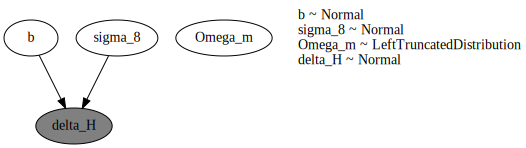

In [ ]:
# Define model and simulate
def model_iso(sigmas, std_omegam):
    b = sample('b', dist.Normal(2,0.1))
    sigma_8 = sample('sigma_8', dist.Normal(0.831,0.2))
    Omega_m = sample('Omega_m', dist.TruncatedNormal(0.25, std_omegam, low=0))
    transfer = b * sigma_8
    delta_H = sample('delta_H', dist.Normal(0, transfer**2 * sigmas**2))
    return delta_H

n_k = 100
std_omegam = 0.01 # NOTE: play with Omega_m information, e.g. std=0.01 vs. 0.1
fiduc = {'sigma_8':0.84, 'b':2.05, 'Omega_m':0.25}

ks = jnp.linspace(1e-1,0.3,n_k)
sigmas = 1e-3 * n_k**.5 / ks
config = dict(sigmas=sigmas, std_omegam=std_omegam)
model = partial(model_iso, **config)

# Simulate
obs = {'delta_H':seed(condition(model, fiduc), 42)()}
# Condition on observations
obs_model_iso = condition(model, obs)
# logp = lambda b, sigma_8: log_density(obs_model, (), {}, {'b':b, 'sigma_8':sigma_8})[0]
render_model(obs_model_iso, render_distributions=True)

### Basic MCMC: Metropolis-Hastings

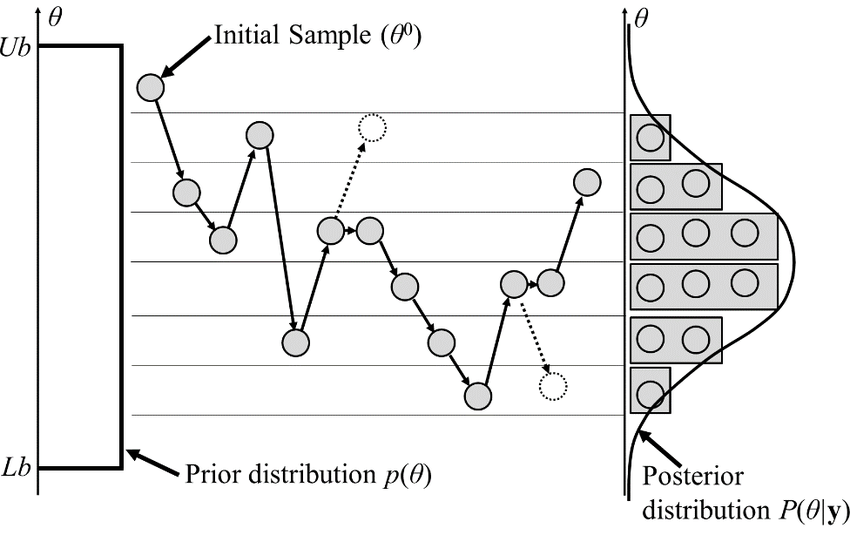

[demo](https://chi-feng.github.io/mcmc-demo/app.html?algorithm=RandomWalkMH&target=banana)

In [ ]:
from numpyro.contrib.tfp.mcmc import MetropolisAdjustedLangevinAlgorithm as MALA, RandomWalkMetropolis as MH
def new_state_fn(state, key):
    diffus = dist.Normal(jnp.zeros(3), 0.1*jnp.ones(3)).sample(key)
    return tree.map(lambda x,y:x+y, state, [diffus])

# Sample from posterior
mh_kernel = MH(model=obs_model_iso, init_strategy=infer.init_to_median(), new_state_fn=new_state_fn,)
mcmc =  infer.MCMC(mh_kernel, num_warmup=1000, num_samples=5000, progress_bar=True)
mcmc.run(jr.key(43))
samples_iso_mh = mcmc.get_samples()
mcmc.print_summary()

sample: 100%|██████████| 6000/6000 [00:02<00:00, 2370.26it/s]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_m      0.25      0.01      0.25      0.23      0.27    344.16      1.00
         b      2.00      0.09      2.00      1.87      2.16    153.05      1.00
   sigma_8      0.89      0.05      0.88      0.81      0.96    173.37      1.00



### Gradient based MCMC: HMC

* To travel farther, add inertia
    1. Augment the sampling space by a momentum space.
    2. At each step sample a momentum
    3. Follow the Hamiltonian dynamic

* More formaly
    1. We augment the target $p(q \mid x_0)$ into $p(q , p \mid x_0) := e^{-H(q,p)}$, where $$H(q,p) := -\log p(q \mid x_0) + \frac 1 2 p^\top M^{-1} p$$
    2. At each proposal step, $p \sim \cN(0,M)$
	3. Follow the Hamiltonian trajectory for some length$$\dot q = \partial_p H \quad;\quad \dot p = -\partial_q H$$Then the arrival is the proposal.
* Way less correlated than MH, cf. [demo](https://arogozhnikov.github.io/2016/12/19/markov_chain_monte_carlo.html)



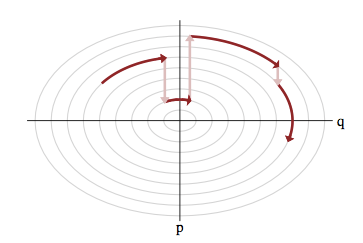
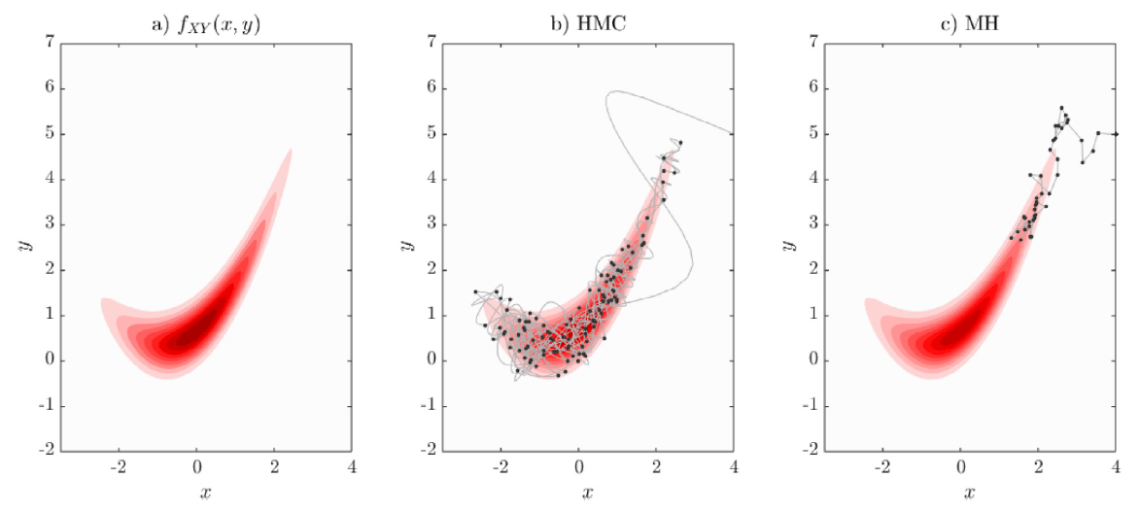

In [ ]:
# Sample from posterior
hmc_kernel = infer.HMC(obs_model_iso, step_size=0.1, init_strategy=infer.init_to_median(),)
mcmc =  infer.MCMC(hmc_kernel, num_warmup=1000, num_samples=5000, progress_bar=True)
mcmc.run(jr.key(43), extra_fields=['num_steps'])
samples_iso, extra = mcmc.get_samples(), mcmc.get_extra_fields()
print("total steps:", extra['num_steps'].sum())
# samples.update(extra)
mcmc.print_summary()

sample: 100%|██████████| 6000/6000 [00:04<00:00, 1441.08it/s, 14 steps of size 4.61e-01. acc. prob=0.96]


total steps: 70000

                mean       std    median      5.0%     95.0%     n_eff     r_hat
   Omega_m      0.25      0.01      0.25      0.23      0.27  11976.32      1.00
         b      2.00      0.10      2.00      1.84      2.17   4223.86      1.00
   sigma_8      0.88      0.05      0.88      0.80      0.97   4173.95      1.00

Number of divergences: 0


Removed no burn in
Removed no burn in


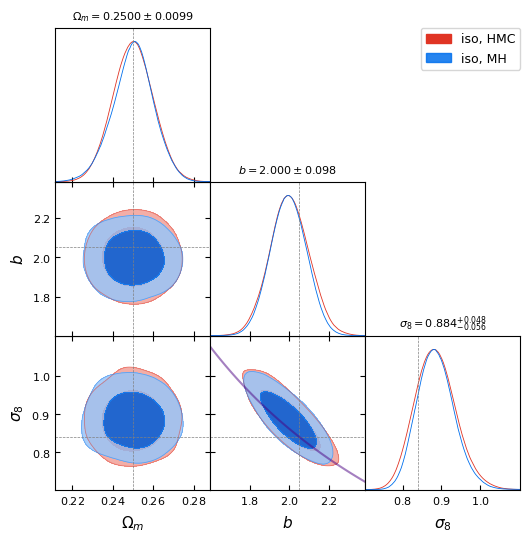

In [ ]:
labels = ["\Omega_m", "b","\sigma_8"]
gdsamp_iso    = MCSamples(samples=list(samples_iso.values()), names=list(samples_iso.keys()), labels=labels, label="iso, HMC")
gdsamp_iso_mh = MCSamples(samples=list(samples_iso_mh.values()), names=list(samples_iso_mh.keys()), labels=labels, label="iso, MH")
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot(roots=[gdsamp_iso, gdsamp_iso_mh], title_limit=1, filled=True, markers=fiduc)
# Add degeneracy lines
ax = g.get_axes(ax=(2,1))
bs = np.linspace(*ax.get_xlim())
ax.plot(bs, fiduc['sigma_8'] * fiduc['b'] / bs, 'indigo', alpha=0.5)
plt.show()

### Let's add RSD: Kaiser model
* Kaiser model assumes$$\delta_H(k, \mu) \simeq (b + f \mu^2) \sigma_8\, \delta_L(k)$$where $\mu := \frac{k_{\text{los}}}{k} = \cos(\theta_{\text{los}})$ and we have the approximation $f \simeq \Omega_m^{0.55}$.

* The likelihood is thus $$\begin{align*}
\delta_H(k) \mid  b, \sigma_8 \sim \cN(0, ((b + f \mu^2) \sigma_8 \sigma_L(k))^2 I)\\
\end{align*}$$ which is still non linear.

* So with respect to $\mu$, $b \sigma_8$ and $f \sigma_8$ respectively sets the elevation and the slope of the observed variance, so this quantities can be well infered. And *a fortiori*, if $\Omega_m$ is well constrained, so is $f$, then so is $\sigma_8$, then so is $b$.

* Moroever, discretization of the Fourrier space yields
$$\dd n(k,\mu) =\rho(k,\mu) \dd k \, \dd \mu \propto k^2 \dd k\, \dd \mu \quad \implies \quad\sigma(k) \propto n(k)^{-1/2} \propto  k^{-1}\sqrt{N_k N_\mu}$$

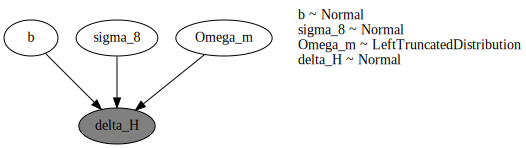

In [ ]:
# Define model and simulate
def model_kaiser(sigmas, mus, std_omegam):
    b = sample('b', dist.Normal(2,0.1))
    sigma_8 = sample('sigma_8', dist.Normal(0.831,0.2))
    Omega_m = sample('Omega_m', dist.TruncatedNormal(0.25, std_omegam, low=0))
    transfer = (b + Omega_m**0.55 * mus**2) * sigma_8
    delta_H = sample('delta_H', dist.Normal(0, transfer**2 * sigmas[:,None]**2))
    return delta_H

n_k, n_mu = 100, 20
ks, mus = jnp.linspace(1e-1,0.3,n_k), jnp.linspace(0,100,n_mu)
sigmas = 1e-3 * (n_k* n_mu)**.5 / ks
config = dict(sigmas=sigmas, mus=mus, std_omegam=std_omegam)
model = partial(model_kaiser, **config)

obs = {'delta_H':seed(condition(model, fiduc), 42)()}
obs_model_kaiser = condition(model, obs)
# logp = lambda b, sigma_8: log_density(obs_model, (), {}, {'b':b, 'sigma_8':sigma_8})[0]
numpyro.render_model(obs_model_kaiser, render_distributions=True)

In [ ]:
# Sample from posterior
hmc_kernel = infer.NUTS(obs_model_kaiser, step_size=0.1, init_strategy=infer.init_to_median(),)
mcmc =  infer.MCMC(hmc_kernel, num_warmup=1000, num_samples=5000, progress_bar=True)
mcmc.run(jr.key(43), extra_fields=['num_steps'])
samples_kaiser, extra = mcmc.get_samples(), mcmc.get_extra_fields()
print("total steps:", extra['num_steps'].sum())
# samples.update(extra)

sample: 100%|██████████| 6000/6000 [00:06<00:00, 932.03it/s, 7 steps of size 2.66e-01. acc. prob=0.93] 


total steps: 53330


Removed no burn in


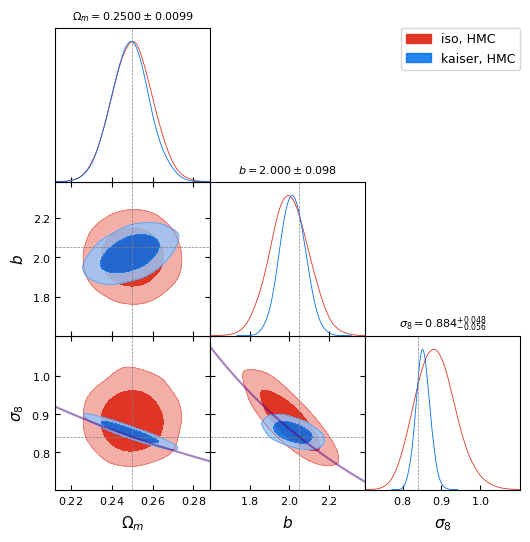

In [ ]:
labels = ["\Omega_m", "b","\sigma_8"]
gdsamp_kaiser = MCSamples(samples=list(samples_kaiser.values()), names=list(samples_kaiser.keys()), labels=labels, label="kaiser, HMC")
g = plots.get_subplot_plotter(width_inch=6)
g.triangle_plot(roots=[gdsamp_iso, gdsamp_kaiser], title_limit=1, filled=True, markers=fiduc)
# Add degeneracy lines
ax = g.get_axes(ax=(2,0))
Oms = np.linspace(*ax.get_xlim())
ax.plot(Oms, fiduc['sigma_8'] * fiduc['Omega_m']**0.55 / Oms**0.55, 'indigo', alpha=0.5)
ax = g.get_axes(ax=(2,1))
bs = np.linspace(*ax.get_xlim())
ax.plot(bs, fiduc['sigma_8'] * fiduc['b'] / bs, 'indigo', alpha=0.5)
plt.show()

# N-body with JaxPM

In [2]:
def get_cosmology(Omega_m, sigma8):
    return jc.Planck15(Omega_c = Omega_m - jc.Planck15.keywords['Omega_b'], sigma8=sigma8)


# def linear_pk_interp(cosmology, a=1., n_interp=256):
#     """
#     Return a light emulation of the linear matter power spectrum.
#     """
#     k = jnp.logspace(-4, 1, n_interp)
#     pk = jc.power.linear_matter_power(cosmology, k, a=a)
#     pk_fn = lambda x: jc.scipy.interpolate.interp(x.reshape(-1), k, pk).reshape(x.shape)
#     return pk_fn


# def get_init_mesh(init_mesh_, cosmology,
#                   mesh_shape, box_shape, **config):
#     """
#     Return initial conditions at a=1 from latent params.
#     """
#     # Compute initial power spectrum
#     pk_fn = linear_pk_interp(cosmology)
#     kvec = fftk(mesh_shape)
#     k_box = sum((ki  * (m / l))**2 for ki, m, l in zip(kvec, mesh_shape, box_shape))**0.5
#     pk_mesh = pk_fn(k_box) * (mesh_shape / box_shape).prod() # NOTE: convert from (Mpc/h)^3 to cell units

#     # Apply transfer function
#     delta_k = jnp.fft.rfftn(init_mesh_)
#     delta_k *= pk_mesh**0.5
#     init_mesh = jnp.fft.irfftn(delta_k)
#     return init_mesh


def nbody(init_mesh, cosmology,
          mesh_shape, a_lpt, a_obs, n_snapshots, **config):
    """
    Compute matter field at a_lpt then evolve it to a_obs.
    """
    # Initial displacement
    pos = jnp.indices(mesh_shape).reshape(3,-1).T
    cosmology._workspace = {}
    dx, p, f = lpt(cosmology, init_mesh, pos, a_lpt)

    # Evolve the simulation forward
    snapshots = jnp.linspace(a_lpt, a_obs, n_snapshots)
    pos, p = odeint(make_ode_fn(mesh_shape), [pos+dx, p], snapshots, cosmology, rtol=1e-3, atol=1e-3)
    return jnp.stack([cic_paint(jnp.zeros(mesh_shape), pos_i) for pos_i in pos])


def mean_model(init_mesh, Omega_m, sigma8, **config):
    cosmology = get_cosmology(Omega_m, sigma8)
    meshes = nbody(init_mesh, cosmology, **config)
    return meshes


def prior_model(mesh_shape, **config):
    init_mesh = sample('init_mesh', dist.Normal(0, 10).expand(mesh_shape))
    Omega_m = sample('Omega_m', dist.TruncatedNormal(0.31, 0.5, low=jc.Planck15.keywords['Omega_b'], high=1.))
    sigma8 = sample('sigma8', dist.TruncatedNormal(0.81,0.5, low=0.))
    params = dict(init_mesh = init_mesh, 
                  Omega_m = Omega_m, 
                  sigma8 = sigma8,)
    return params


def lik_model(params, std_obs, **config):
    mean_mesh = mean_model(**params, **config | dict(n_snapshots=2))[-1]
    return sample('obs_mesh', dist.Normal(mean_mesh, std_obs))


def model(**config):
    params = prior_model(**config)
    return lik_model(params, **config)

In [3]:
from matplotlib import animation, rc
rc('animation', html='html5')

def plot_mesh(meshes, i, vlim, cmap="gray", **config):
    mesh_shape, box_shape = config['mesh_shape'], config['box_shape']
    xx, yy = np.indices(mesh_shape[:2]) * (box_shape/mesh_shape)[:2,None,None]
    vmin, vmax = vlim

    quad = plt.pcolormesh(xx, yy, meshes[i].mean(-1), vmin=vmin, vmax=vmax, cmap=cmap)
    plt.xlabel("$x$ [Mpc/$h$]"), plt.ylabel("$y$ [Mpc/$h$]")
    plt.gca().set_aspect(1)
    return quad

def plot_meshes(meshes, titles=None, joint_scale=True, cmap="gray", **config):
    meshes = jnp.asarray(meshes)
    if joint_scale:
        vlim = jnp.quantile(meshes, 0.01), jnp.quantile(meshes, 0.99)
    else:
        vlim = None,None

    plt.figure(figsize=(6*len(meshes), 6))
    for i_mesh, mesh in enumerate(meshes):
        plt.subplot(1, len(meshes), i_mesh+1)
        plot_mesh(meshes, i_mesh, vlim, cmap, **config)

        if titles is not None:
            plt.title(titles[i_mesh])
        if not joint_scale:
            plt.colorbar()
    plt.tight_layout()
    plt.show()

def animate_meshes(meshes, cmap="gray", **config):
    meshes = jnp.asarray(meshes)
    vlim = jnp.quantile(meshes, 0.01), jnp.quantile(meshes, 0.99)
    quad = plot_mesh(meshes, 0, vlim, cmap, **config)
    plt.colorbar()

    def update(i):
        if i < len(meshes):
            quad.set_array(meshes[i].mean(-1))
        return quad,

    anim = animation.FuncAnimation(plt.gcf(), update, frames=len(meshes)+10, interval=100, blit=True)
    plt.close()
    display(anim)

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

2024-11-14 13:15:22.727920: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


obs_mesh.shape=(64, 64, 4)


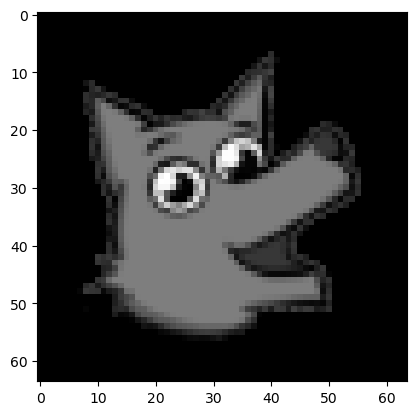

In [4]:
from PIL import Image
def load_image(im_path):
    img = Image.open(im_path).convert("L")
    return np.array(img)

# im_path = "BaoBan_g128.png"
# im_path = "./figs/BaoBan_128.png"
im_path = "./figs/BaoBan_64.png"
img = load_image(im_path)
display(img)
plt.imshow(img, cmap='gray');

depth = 4
obs_mesh = jnp.broadcast_to(img[::-1].T[...,None], (*img.shape, depth))
obs_mesh = obs_mesh.astype(jnp.float32) / 255. * 10
print(f"{obs_mesh.shape=}")

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit

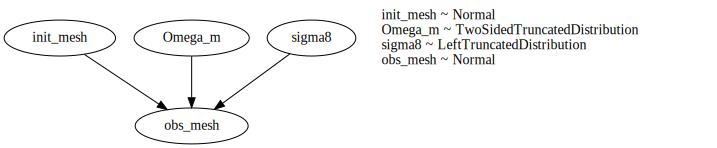

In [5]:
config = {
    'mesh_shape': obs_mesh.shape,
    'box_shape': np.array(obs_mesh.shape), # in Mpc/h
    'a_lpt': 0.01,
    'a_obs': 1.,
    'std_obs': .1,
    'n_snapshots': 30,
}

model = partial(model, **config)
render_model(model, render_distributions=True, render_params=True)

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


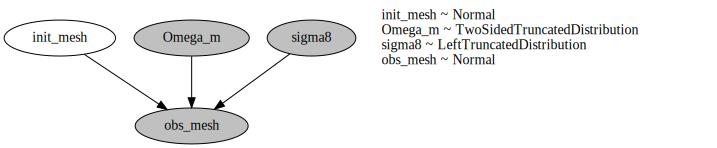

In [6]:
params = dict(init_mesh = jr.normal(jr.key(0), config['mesh_shape']),)
obs = dict(obs_mesh=obs_mesh)
cosmo = dict(Omega_m=0.31, sigma8=0.81)
obs |= cosmo

obs_model = condition(model, obs)
render_model(obs_model, render_distributions=True, render_params=True)

# Posterior mode

In [7]:
energy_fn = lambda params: -log_density(obs_model, (), {}, params)[0]
energy_valgrad_fn = jit(value_and_grad(energy_fn))

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


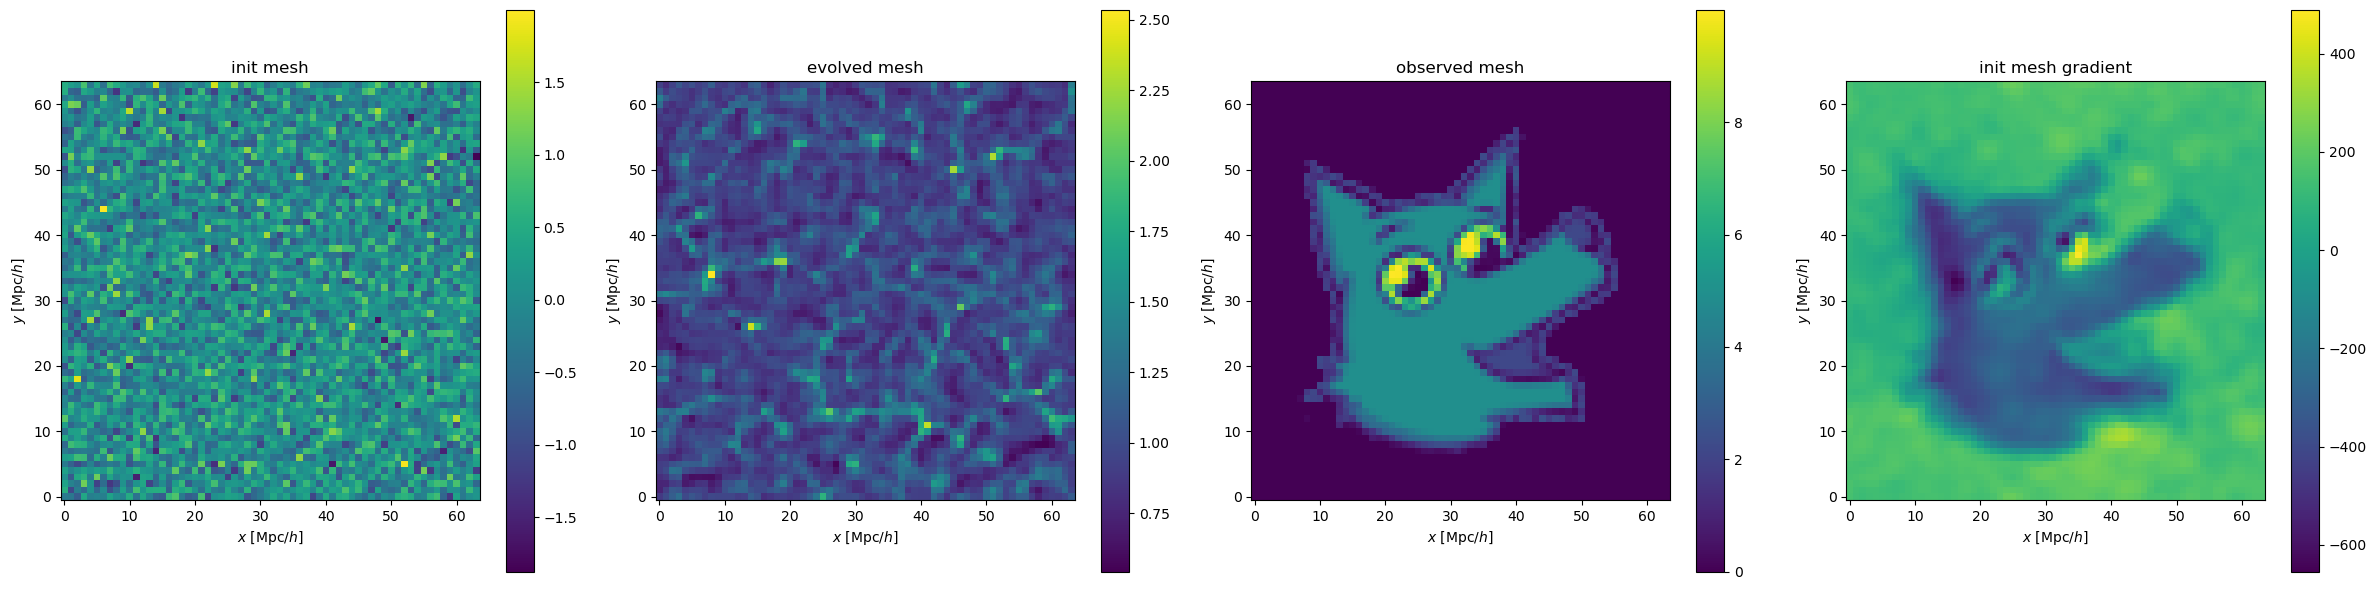

In [ ]:
get_meshes = partial(mean_model, **cosmo, **config)
def plot_optim_state(params):
    meshes = get_meshes(**params)
    animate_meshes(meshes, **config)
    # plot_meshes(meshes, **config)

    meshes = jnp.stack([params['init_mesh'], meshes[-1], obs_mesh, energy_valgrad_fn(params)[1]['init_mesh']])
    titles = ['init', 'evolved', 'observed', 'gradient']
    plot_meshes(meshes, titles, joint_scale=False, cmap='viridis', **config)

plot_optim_state(params)

In [9]:
from jax.example_libraries.optimizers import adam
from tqdm import tqdm
lr0 = .1
n_epochs = 300
energies = []

lr_fn = lambda i: lr0 / (1 + i)**.5
opt_init, opt_update, get_params = adam(lr_fn)
opt_state = opt_init(params)

def step(step, opt_state):
    value, grads = energy_valgrad_fn(get_params(opt_state))
    opt_state = opt_update(step, grads, opt_state)
    return value, opt_state

for i_epoch in tqdm(range(n_epochs)):
    value, opt_state = step(i_epoch, opt_state)
    energies.append(float(value))
params = get_params(opt_state)

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:37<00:00,  7.94it/s]


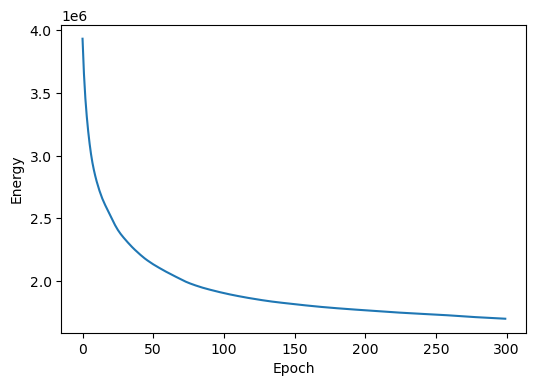

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)


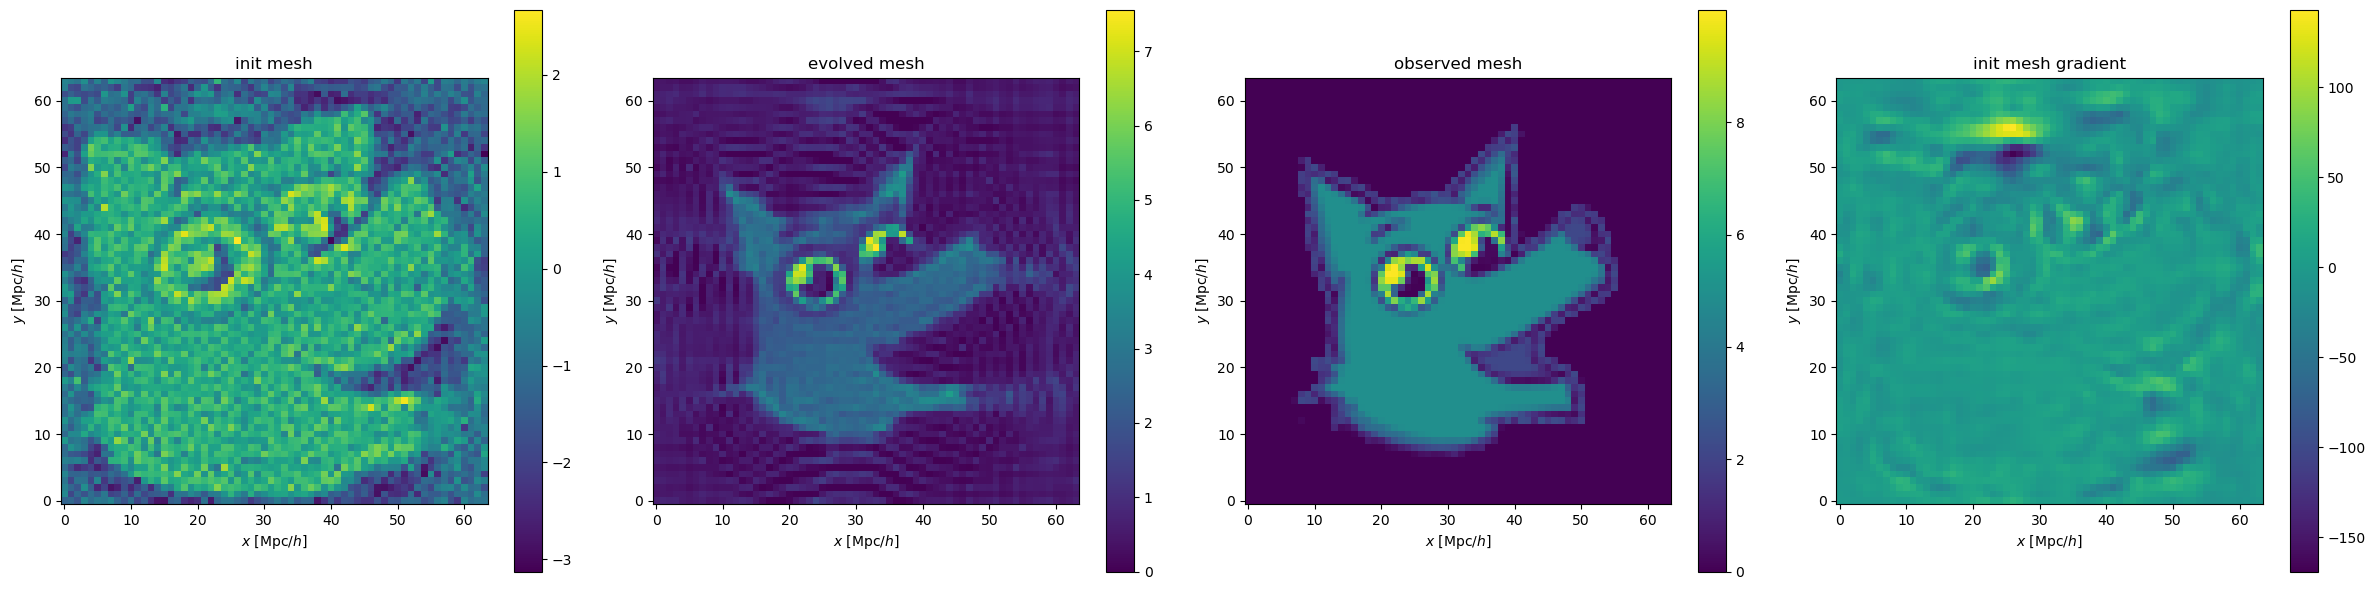

In [10]:
plt.figure(figsize=(6,4))
plt.plot(energies)
plt.xlabel("Epoch"), plt.ylabel("Energy")
plt.show()
plot_optim_state(params)

# Posterior sampling

In [ ]:
nuts_kernel = infer.NUTS(obs_model, init_strategy=infer.init_to_sample(),)
mcmc =  infer.MCMC(nuts_kernel, num_warmup=100, num_samples=1000, progress_bar=True)
mcmc.run(jr.key(43), extra_fields=['num_steps'])
samples, extra = mcmc.get_samples(), mcmc.get_extra_fields()
print("total steps:", extra['num_steps'].sum())
mcmc.print_summary()

/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:66: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return lax_numpy.astype(arr, dtype)
/feynman/work/dphp/hs276503/envs/montenvtest3/lib/python3.12/sit